# **Step 1 | Setup and Initialization**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video

In [ ]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

# **Step 2 | Loading YOLOv8 Pre-trained Model**

**Here are the pre-trained YOLOv8 object detection models, which have been trained on the COCO dataset. The Common Objects in Context (COCO) dataset is extensive, designed for object detection, segmentation, and captioning, and encompasses 80 diverse object categories:**

**For our real-time traffic density estimation application, I am going to select the YOLOv8 nano pre-trained model (yolov8n.pt) to handle vehicle detection. This model ensures the fastest possible inference time, making it well-suited for real-time use:**

In [ ]:
# Load a pretrained YOLOv8n model from Ultralytics
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 104MB/s]


In [ ]:
# Path to the image file
image_path = './sample_image.jpg'

# Perform inference on the provided image(s)
results = model.predict(source=image_path,
                        imgsz=640,  # Resize image to 640x640 (the size pf images the model was trained on)
                        conf=0.5)   # Confidence threshold: 50% (only detections above 50% confidence will be considered)

# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Pre-trained YOLOv8 Model on COCO Dataset', fontsize=20)
plt.axis('off')
plt.show()

FileNotFoundError: ./sample_image.jpg does not exist

# **Step 3 | Dataset Exploration**

Let's begin our exploration by examining the 'data.yaml' file:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Major/vehicle.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Major/vehicle.zip
  inflating: Vehicle_Detection_Image_Dataset/README.dataset.txt  
  inflating: Vehicle_Detection_Image_Dataset/README.roboflow.txt  
  inflating: Vehicle_Detection_Image_Dataset/data.yaml  
  inflating: Vehicle_Detection_Image_Dataset/sample_image.jpg  
  inflating: Vehicle_Detection_Image_Dataset/sample_video.mp4  
  inflating: Vehicle_Detection_Image_Dataset/train/images/10_mp4-10_jpg.rf.b87509668caff369c5501325477e6d9a.jpg  
  inflating: Vehicle_Detection_Image_Dataset/train/images/10_mp4-10_jpg.rf.ba480b311472ef957256801c3766128a.jpg  
  inflating: Vehicle_Detection_Image_Dataset/train/images/10_mp4-11_jpg.rf.eb1b06090bd1c1814b87c18a2661990a.jpg  
  inflating: Vehicle_Detection_Image_Dataset/train/images/10_mp4-12_jpg.rf.daf65f51adfd1817d026f3d4c3cf3d4c.jpg  
  inflating: Vehicle_Detection_Image_Dataset/t

In [ ]:
# Define the dataset_path
dataset_path = '/content/drive/MyDrive/vehicle/Vehicle_Detection_Image_Dataset'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: ../train/images
val: ../valid/images



In [ ]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


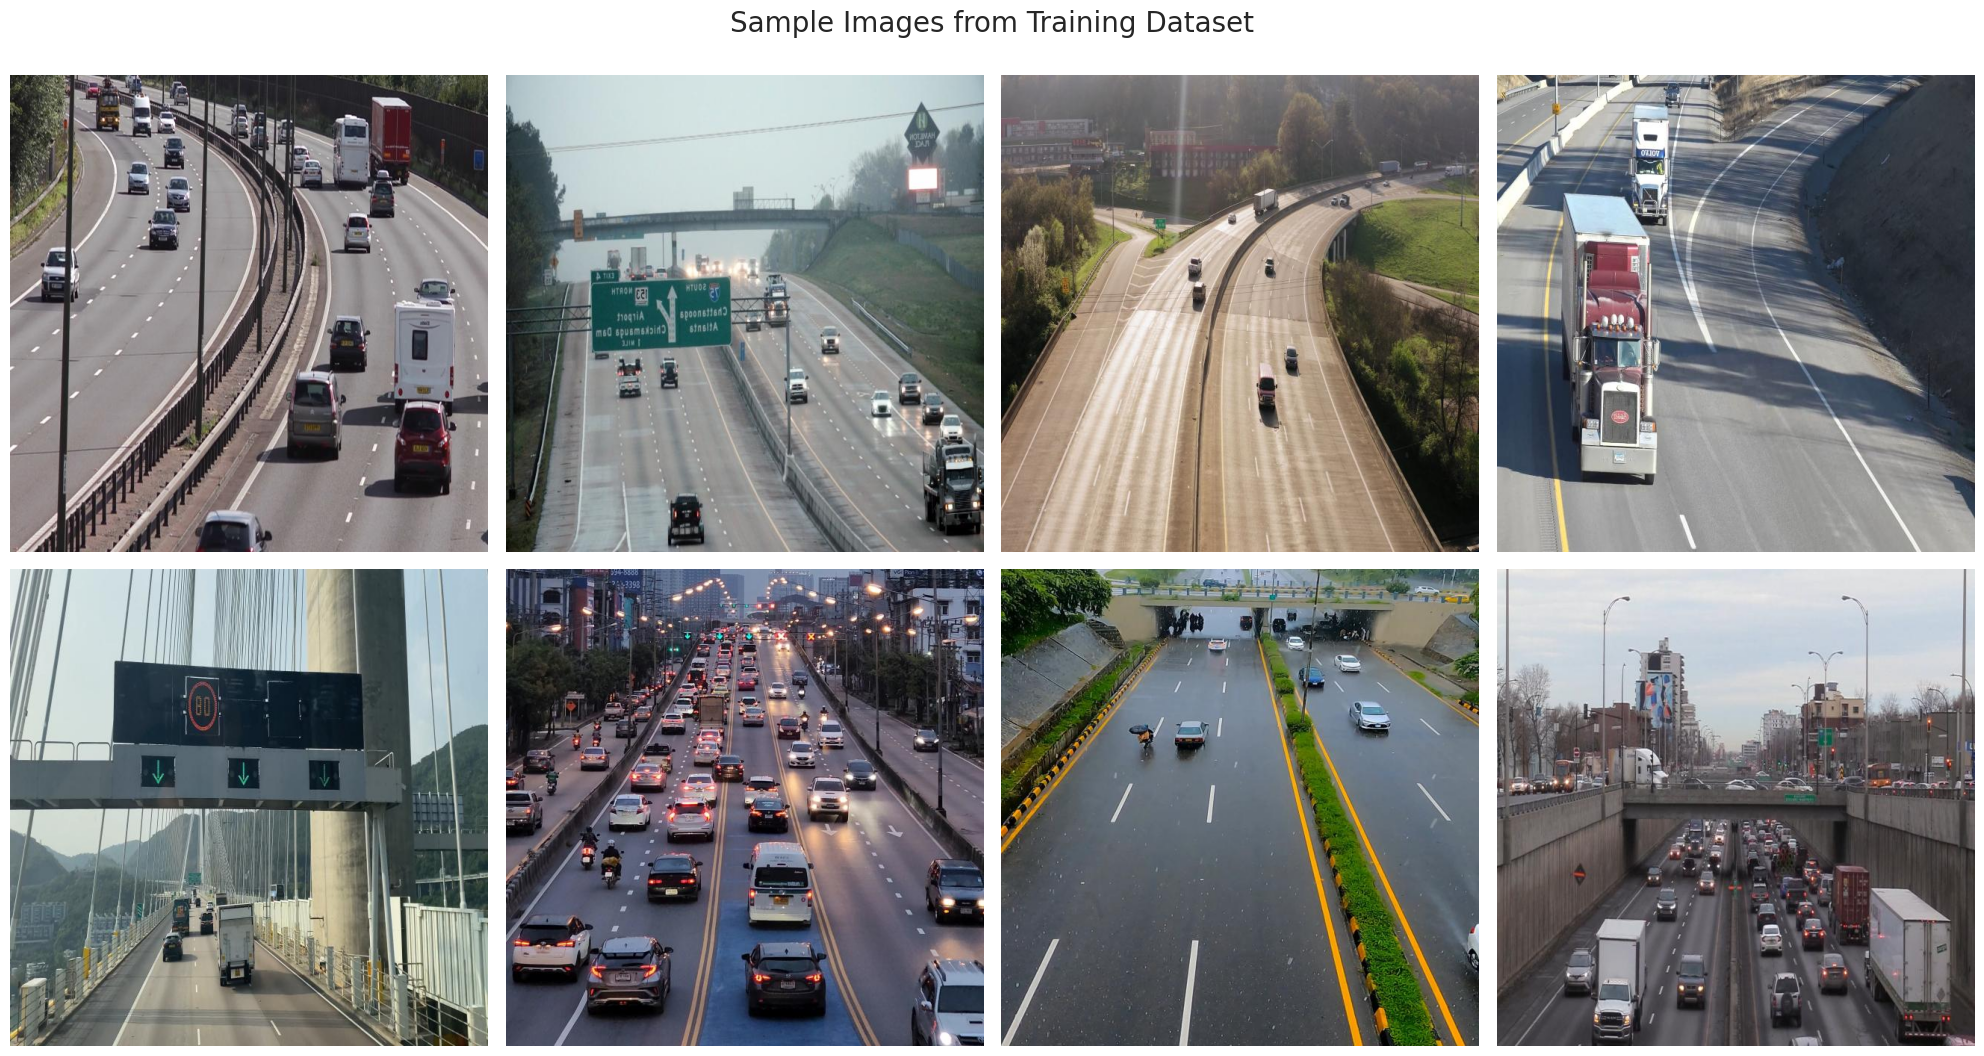

In [ ]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

# Create a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# Train the model on our custom dataset
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=50,              # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    device=0,                # Device to run on, i.e. cuda device=0
    patience=50,             # Epochs to wait for no observable improvement for early stopping of training
    batch=32,                # Number of images per batch
    optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # Initial learning rate
    lrf=0.1,                 # Final learning rate (lr0 * lrf)
    dropout=0.1,             # Use dropout regularization
    seed=0                   # Random seed for reproducibility
)

New https://pypi.org/project/ultralytics/8.2.26 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.25 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/vehicle/Vehicle_Detection_Image_Dataset/data.yaml, epochs=50, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

100%|██████████| 755k/755k [00:00<00:00, 28.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/vehicle/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [03:28<00:00,  2.57it/s]


train: New cache created: /content/drive/MyDrive/vehicle/Vehicle_Detection_Image_Dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/vehicle/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s]

val: New cache created: /content/drive/MyDrive/vehicle/Vehicle_Detection_Image_Dataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       5.1G      2.428      2.967      1.852        271        640: 100%|██████████| 17/17 [00:19<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.55s/it]

                   all         90        937    0.00374      0.108    0.00366    0.00133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.32G      1.518      1.301      1.198        365        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         90        937    0.00878      0.253     0.0621     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         5G      1.276     0.9909      1.063        310        640: 100%|██████████| 17/17 [00:09<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         90        937      0.916      0.618      0.713      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.88G      1.209     0.8838       1.03        310        640: 100%|██████████| 17/17 [00:11<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         90        937      0.836      0.835      0.898      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.58G      1.182     0.8404      1.017        421        640: 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         90        937      0.828      0.839      0.902       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.54G       1.15     0.7968      1.005        296        640: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         90        937      0.838      0.855       0.91      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.61G      1.123     0.7476     0.9916        309        640: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         90        937      0.841       0.89      0.936      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.83G       1.12     0.7291     0.9923        389        640: 100%|██████████| 17/17 [00:11<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]

                   all         90        937      0.858      0.898      0.949      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.43G        1.1     0.6973     0.9783        469        640: 100%|██████████| 17/17 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         90        937      0.891      0.913      0.955      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.78G      1.091     0.6901     0.9822        221        640: 100%|██████████| 17/17 [00:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         90        937      0.854      0.904      0.944       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       4.9G      1.071     0.6557     0.9778        298        640: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         90        937       0.88      0.925      0.961      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.65G      1.082     0.6647     0.9843        341        640: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         90        937      0.885      0.924      0.965      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.93G      1.071     0.6481     0.9692        426        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         90        937       0.87      0.921      0.955      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.93G      1.056     0.6242     0.9733        434        640: 100%|██████████| 17/17 [00:10<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         90        937      0.893      0.904      0.957      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.67G      1.058     0.6341     0.9733        308        640: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         90        937      0.887      0.918      0.962      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.09G      1.033      0.606     0.9605        263        640: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         90        937      0.873      0.918      0.951      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.97G      1.033     0.5953     0.9549        417        640: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

                   all         90        937      0.884      0.921      0.956      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.33G      1.015     0.5885     0.9573        322        640: 100%|██████████| 17/17 [00:09<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         90        937      0.886      0.933      0.961      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.82G      1.035     0.6162     0.9554        288        640: 100%|██████████| 17/17 [00:11<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         90        937      0.904      0.917      0.966      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.05G      1.028     0.5883     0.9538        320        640: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         90        937      0.893      0.939      0.964      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.24G      1.015     0.5869     0.9539        379        640: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         90        937      0.908      0.919      0.966      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.66G       1.01     0.5747     0.9567        363        640: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         90        937      0.899      0.923      0.962      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.22G     0.9919     0.5583     0.9503        303        640: 100%|██████████| 17/17 [00:09<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         90        937      0.898      0.921      0.966      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.31G      0.992     0.5732     0.9477        274        640: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         90        937      0.895      0.931      0.957      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.29G      1.004     0.5686     0.9521        482        640: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         90        937      0.911       0.91      0.965      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       4.9G      1.021     0.5749     0.9515        346        640: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         90        937      0.911      0.926      0.972      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.69G     0.9813     0.5479     0.9519        407        640: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         90        937      0.907      0.933       0.97      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       4.7G     0.9787     0.5395     0.9461        400        640: 100%|██████████| 17/17 [00:09<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         90        937      0.919      0.946      0.977      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.88G     0.9799     0.5368     0.9416        264        640: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         90        937      0.908      0.919      0.972      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.47G     0.9707     0.5315     0.9397        309        640: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         90        937      0.913      0.922      0.972      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.66G     0.9648     0.5292     0.9379        285        640: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         90        937      0.893      0.937      0.965      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.91G     0.9749       0.54     0.9408        439        640: 100%|██████████| 17/17 [00:10<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         90        937      0.916      0.924      0.971      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.87G     0.9559     0.5277     0.9368        274        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         90        937      0.926      0.923      0.969      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.99G     0.9477     0.5161     0.9317        427        640: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         90        937      0.907       0.94      0.974      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.58G     0.9602     0.5209      0.933        350        640: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         90        937      0.898       0.94      0.973      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.65G     0.9625     0.5231     0.9423        308        640: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         90        937      0.899       0.94      0.963      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.93G     0.9397     0.5118     0.9327        329        640: 100%|██████████| 17/17 [00:09<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         90        937      0.913      0.927      0.975      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.02G     0.9458      0.516      0.931        406        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         90        937      0.913      0.942      0.969      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.91G     0.9478     0.5067     0.9277        290        640: 100%|██████████| 17/17 [00:14<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         90        937      0.901       0.95      0.974      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.68G     0.9454     0.5063     0.9324        296        640: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         90        937      0.915      0.936      0.969      0.726


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       4.8G     0.9285      0.482     0.9313        249        640: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         90        937      0.903      0.927      0.967      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.44G     0.9211     0.4848     0.9308        235        640: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all         90        937      0.907      0.953      0.977      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.42G     0.9098     0.4719      0.924        288        640: 100%|██████████| 17/17 [00:09<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         90        937      0.916      0.932      0.968      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       4.4G     0.8981     0.4702     0.9213        315        640: 100%|██████████| 17/17 [00:10<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         90        937      0.912      0.934      0.974       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.43G     0.8992      0.467     0.9208        191        640: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         90        937      0.922       0.93      0.973      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.45G     0.8894     0.4584     0.9205        159        640: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         90        937      0.902      0.946      0.973      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       4.4G     0.8907     0.4544      0.922        230        640: 100%|██████████| 17/17 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         90        937      0.914      0.939      0.973      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.37G     0.8931     0.4535     0.9225        174        640: 100%|██████████| 17/17 [00:10<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         90        937      0.917      0.936      0.974       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       4.4G     0.8765     0.4446     0.9223        269        640: 100%|██████████| 17/17 [00:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         90        937      0.916      0.936      0.975      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.39G     0.8782     0.4468     0.9204        298        640: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

                   all         90        937      0.903      0.943      0.969      0.727



50 epochs completed in 0.231 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.25 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


                   all         90        937      0.913      0.941      0.969      0.732
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train


# **Model Performance Evaluation**

In [ ]:
import os

# Define the path to the directory
post_training_files_path = '/content/runs/detect/train'

# List the files in the directory
files = os.listdir(post_training_files_path)
for file in files:
    print(file)

train_batch2.jpg
train_batch680.jpg
events.out.tfevents.1717062418.46b0bea98420.218.0
val_batch1_pred.jpg
args.yaml
confusion_matrix_normalized.png
F1_curve.png
val_batch1_labels.jpg
weights
P_curve.png
labels_correlogram.jpg
results.csv
train_batch682.jpg
train_batch0.jpg
labels.jpg
val_batch0_pred.jpg
train_batch1.jpg
results.png
R_curve.png
val_batch0_labels.jpg
train_batch681.jpg
confusion_matrix.png
PR_curve.png


# **Step 6 | Model Inference & Generalization Assessment**

**Step 6.1 | Inference on Validation Set Images**

In [ ]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640, conf=0.5)
    annotated_image = results[0].plot(line_width=1)
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()

**Step 6.2 | Inference on an Unseen Test Image**

In [ ]:
# Path to the image file
sample_image_path = '/content/sample_image.jpg'

# Perform inference on the provided image using best model
results = best_model.predict(source=sample_image_path, imgsz=640, conf=0.7)

# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Fine-tuned YOLOv8 Model', fontsize=20)
plt.axis('off')
plt.show()

**Step 6.3 | Inference on an Unseen Test Video**

In [ ]:
# Define the path to the sample video in the dataset
dataset_video_path = '/content/Dehu.mp4'

# Define the destination path in the working directory
video_path = '/content/working/Dehu.mp4'
# Copy the video file from its original location in the dataset to the current working directory in Kaggle for further processing
shutil.copyfile(dataset_video_path, video_path)

# Initiate vehicle detection on the sample video using the best performing model and save the output
best_model.predict(source=video_path, save=True)

In [ ]:
from moviepy.editor import VideoFileClip

# Define input and output file paths
input_video_path = "/content/runs/detect/predict/Dehu.avi"
output_video_path = "/content/processed_Dehu.mp4"

# Load video clip
clip = VideoFileClip(input_video_path)

# Write the clip to a new file in mp4 format
clip.write_videofile(output_video_path)


In [ ]:
# Convert the .avi video generated by the YOLOv8 prediction to .mp4 format for compatibility with notebook display
# !ffmpeg -y -loglevel panic -i /content/runs/detect/predict/sample_video.avi processed_sample_video.mp4

# Embed and display the processed sample video within the notebook
Video("processed_Dehu.mp4", embed=True, width=960)

# **Step 7 | Real-Time Traffic Intensity Estimation**

In [ ]:
# Define the threshold for considering traffic as heavy
heavy_traffic_threshold = 10

# Define the vertices for the quadrilaterals
vertices1 = np.array([(465, 350), (609, 350), (510, 630), (2, 630)], dtype=np.int32)
vertices2 = np.array([(678, 350), (815, 350), (1203, 630), (743, 630)], dtype=np.int32)

# Define the vertical range for the slice and lane threshold
x1, x2 = 325, 635
lane_threshold = 609

# Define the positions for the text annotations on the image
text_position_left_lane = (10, 50)
text_position_right_lane = (820, 50)
intensity_position_left_lane = (10, 100)
intensity_position_right_lane = (820, 100)

# Define font, scale, and colors for the annotations
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)    # White color for text
background_color = (0, 0, 255)  # Red background for text

# Open the video
cap = cv2.VideoCapture('sample_video.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('traffic_density_analysis.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Read until video is completed
while cap.isOpened():
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:
        # Create a copy of the original frame to modify
        detection_frame = frame.copy()

        # Black out the regions outside the specified vertical range
        detection_frame[:x1, :] = 0  # Black out from top to x1
        detection_frame[x2:, :] = 0  # Black out from x2 to the bottom of the frame

        # Perform inference on the modified frame
        results = best_model.predict(detection_frame, imgsz=640, conf=0.4)
        processed_frame = results[0].plot(line_width=1)

        # Restore the original top and bottom parts of the frame
        processed_frame[:x1, :] = frame[:x1, :].copy()
        processed_frame[x2:, :] = frame[x2:, :].copy()

        # Draw the quadrilaterals on the processed frame
        cv2.polylines(processed_frame, [vertices1], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(processed_frame, [vertices2], isClosed=True, color=(255, 0, 0), thickness=2)

        # Retrieve the bounding boxes from the results
        bounding_boxes = results[0].boxes

        # Initialize counters for vehicles in each lane
        vehicles_in_left_lane = 0
        vehicles_in_right_lane = 0

        # Loop through each bounding box to count vehicles in each lane
        for box in bounding_boxes.xyxy:
            # Check if the vehicle is in the left lane based on the x-coordinate of the bounding box
            if box[0] < lane_threshold:
                vehicles_in_left_lane += 1
            else:
                vehicles_in_right_lane += 1

        # Determine the traffic intensity for the left lane
        traffic_intensity_left = "Heavy" if vehicles_in_left_lane > heavy_traffic_threshold else "Smooth"
        # Determine the traffic intensity for the right lane
        traffic_intensity_right = "Heavy" if vehicles_in_right_lane > heavy_traffic_threshold else "Smooth"


        # Add a background rectangle for the left lane vehicle count
        cv2.rectangle(processed_frame, (text_position_left_lane[0]-10, text_position_left_lane[1] - 25),
                      (text_position_left_lane[0] + 460, text_position_left_lane[1] + 10), background_color, -1)

        # Add the vehicle count text on top of the rectangle for the left lane
        cv2.putText(processed_frame, f'Vehicles in Left Lane: {vehicles_in_left_lane}', text_position_left_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the left lane traffic intensity
        cv2.rectangle(processed_frame, (intensity_position_left_lane[0]-10, intensity_position_left_lane[1] - 25),
                      (intensity_position_left_lane[0] + 460, intensity_position_left_lane[1] + 10), background_color, -1)

        # Add the traffic intensity text on top of the rectangle for the left lane
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_left}', intensity_position_left_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the right lane vehicle count
        cv2.rectangle(processed_frame, (text_position_right_lane[0]-10, text_position_right_lane[1] - 25),
                      (text_position_right_lane[0] + 460, text_position_right_lane[1] + 10), background_color, -1)

        # Add the vehicle count text on top of the rectangle for the right lane
        cv2.putText(processed_frame, f'Vehicles in Right Lane: {vehicles_in_right_lane}', text_position_right_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Add a background rectangle for the right lane traffic intensity
        cv2.rectangle(processed_frame, (intensity_position_right_lane[0]-10, intensity_position_right_lane[1] - 25),
                      (intensity_position_right_lane[0] + 460, intensity_position_right_lane[1] + 10), background_color, -1)

        # Add the traffic intensity text on top of the rectangle for the right lane
        cv2.putText(processed_frame, f'Traffic Intensity: {traffic_intensity_right}', intensity_position_right_lane,
                    font, font_scale, font_color, 2, cv2.LINE_AA)

        # Write the processed frame to the output video
        out.write(processed_frame)

        # Uncomment the following 3 lines if running this code on a local machine to view the real-time processing results
        # cv2.imshow('Real-time Analysis', processed_frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'):  # Press Q on keyboard to exit the loop
        #     break
    else:
        break

# Release the video capture and video write objects
cap.release()
out.release()

# Close all the frames
# cv2.destroyAllWindows()

In [ ]:
from moviepy.editor import VideoFileClip

# Define input and output file paths
input_video_path = "/content/traffic_density_analysis.avi"
output_video_path = "/content/traffic_density_analysis.mp4"

# Load video clip
clip = VideoFileClip(input_video_path)

# Write the clip to a new file in mp4 format
clip.write_videofile(output_video_path)


In [ ]:
# Convert the .avi video generated by our traffic density estimation app to .mp4 format for compatibility with notebook display
# !ffmpeg -y -loglevel panic -i /kaggle/working/traffic_density_analysis.avi traffic_density_analysis.mp4

# Embed and display the processed sample video within the notebook
Video("traffic_density_analysis.mp4", embed=True, width=960)

# **Step 8 | Model Export for Cross-Platform Deployment**

In [ ]:
# Export the model
best_model.export(format='h5')